In [68]:
import psycopg2
import pandas as pd

### Postgres functions definition

In [69]:
def create_database():
    # connection to the default database
    conn = psycopg2.connect("host=127.0.0.1 dbname=postgres user=postgres password=root")
    conn.set_session(autocommit=True)
    cur = conn.cursor()

    # creating new database named accounts
    cur.execute("DROP DATABASE IF EXISTS accounts")
    cur.execute("CREATE DATABASE accounts")

    # close connection to the default dabase
    conn.close()

    # connection to the new database
    conn = psycopg2.connect("host=127.0.0.1 dbname=accounts user=postgres password=root")
    cur = conn.cursor()

    return cur, conn


In [70]:
def drop_tables(cur, conn):
    for query in drop_table_queries:
        cur.execute(query)
        conn.commit()

In [71]:
def create_tables(cur,conn):
    for query in create_table_queries:
        cur.execute(query)
        conn.commit()

### .csv Data import and cleaning

In [72]:
CountryData = pd.read_csv("datasets/Wealth-AccountsCountry.csv")
CountryData.head()

,Code,Long Name,Income Group,Region,Lending category,Other groups,Currency Unit,Latest population census,Latest household survey,Special Notes,...,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,2-alpha code,WB-2 code,Table Name,Short Name
0,ALB,Republic of Albania,Upper middle income,Europe & Central Asia,IBRD,NaN,Albanian lek,2020 (expected),"Demographic and Health Survey, 2017/18",NaN,...,Living Standards Measurement Study Survey (LSM...,Yes,2012,2013.0,2018.0,2006.0,AL,AL,Albania,Albania
1,ARG,Argentine Republic,Upper middle income,Latin America & Caribbean,IBRD,NaN,Argentine peso,2020 (expected),"Multiple Indicator Cluster Survey, 2019/20",NaN,...,"Integrated household survey (IHS), 2016",Yes,2008,2002.0,2018.0,2011.0,AR,AR,Argentina,Argentina
2,ARM,Republic of Armenia,Upper middle income,Europe & Central Asia,IBRD,NaN,Armenian dram,2020 (expected),"Demographic and Health Survey, 2015/16",NaN,...,"Integrated household survey (IHS), 2016",Yes,2014,NaN,2018.0,2012.0,AM,AM,Armenia,Armenia
3,AUS,Commonwealth of Australia,High income,East Asia & Pacific,NaN,NaN,Australian dollar,2016,NaN,Fiscal year end: June 30; reporting period for...,...,"Expenditure survey/budget survey (ES/BS), 2010",Yes,2015-2016,2013.0,2018.0,2013.0,AU,AU,Australia,Australia
4,AUT,Republic of Austria,High income,Europe & Central Asia,NaN,Euro area,Euro,2011. Population figures compiled from adminis...,NaN,A simple multiplier is used to convert the nat...,...,"Income survey (IS), 2015",Yes,2010,2014.0,2018.0,2010.0,AT,AT,Austria,Austria


In [73]:
CountryData.rename(columns={'Code':'Country Code'}, inplace=True)
CountryData_clean = CountryData[['Country Code','Short Name','Table Name','Long Name','Currency Unit']]
CountryData_clean = CountryData_clean.drop_duplicates(subset=['Country Code'])
CountryData_clean = CountryData_clean.dropna(subset=['Country Code'])
CountryData_clean = CountryData_clean.sort_values(by='Country Code')
CountryData_clean.head()

,Country Code,Short Name,Table Name,Long Name,Currency Unit
0,ALB,Albania,Albania,Republic of Albania,Albanian lek
136,ARE,United Arab Emirates,United Arab Emirates,United Arab Emirates,U.A.E. dirham
1,ARG,Argentina,Argentina,Argentine Republic,Argentine peso
2,ARM,Armenia,Armenia,Republic of Armenia,Armenian dram
3,AUS,Australia,Australia,Commonwealth of Australia,Australian dollar


In [74]:
AccountData = pd.read_csv("datasets/Wealth-AccountData.csv")
AccountData.columns = ['Country Name', 'Country Code', 'Indicator Name', 'Series Code',
       '1995_[YR1995]', '1996_[YR1996]', '1997_[YR1997]', '1998_[YR1998]',
       '1999_[YR1999]', '2000_[YR2000]', '2001_[YR2001]', '2002_[YR2002]',
       '2003_[YR2003]', '2004_[YR2004]', '2005_[YR2005]', '2006_[YR2006]',
       '2007_[YR2007]', '2008_[YR2008]', '2009_[YR2009]', '2010_[YR2010]',
       '2011_[YR2011]', '2012_[YR2012]', '2013_[YR2013]', '2014_[YR2014]',
       '2015_[YR2015]', '2016_[YR2016]', '2017_[YR2017]', '2018_[YR2018]']

AccountData_clean = AccountData.replace('..',0)

columns_conversion_tonumeric = ['1995_[YR1995]', '1996_[YR1996]', '1997_[YR1997]', '1998_[YR1998]',
       '1999_[YR1999]', '2000_[YR2000]', '2001_[YR2001]', '2002_[YR2002]',
       '2003_[YR2003]', '2004_[YR2004]', '2005_[YR2005]', '2006_[YR2006]',
       '2007_[YR2007]', '2008_[YR2008]', '2009_[YR2009]', '2010_[YR2010]',
       '2011_[YR2011]', '2012_[YR2012]', '2013_[YR2013]', '2014_[YR2014]',
       '2015_[YR2015]', '2016_[YR2016]', '2017_[YR2017]', '2018_[YR2018]']

for col in columns_conversion_tonumeric:
    AccountData_clean[col] = pd.to_numeric(AccountData_clean[col])


AccountData_clean.fillna("",inplace=True)

columns_to_keep = ['Country Name', 'Country Code', 'Indicator Name', 'Series Code',
                   '1995_[YR1995]', '2000_[YR2000]', '2005_[YR2005]', '2010_[YR2010]', '2014_[YR2014]']

AccountData_clean = AccountData_clean[columns_to_keep]


AccountData_clean.head()

,Country Name,Country Code,Indicator Name,Series Code,1995_[YR1995],2000_[YR2000],2005_[YR2005],2010_[YR2010],2014_[YR2014]
0,Albania,ALB,Human capital (constant 2018 US$),NW.HCA.TO,4.490000e+10,4.360000e+10,5.440000e+10,6.810000e+10,7.250000e+10
1,Albania,ALB,Human capital per capita (constant 2018 US$),NW.HCA.PC,1.407279e+04,1.411813e+04,1.807230e+04,2.336286e+04,2.509002e+04
2,Albania,ALB,"Human capital per capita, employed female (con...",NW.HCA.FEMP.PC,3.468858e+03,3.424007e+03,2.222115e+03,2.889150e+03,2.957420e+03
3,Albania,ALB,"Human capital per capita, employed male (const...",NW.HCA.MEMP.PC,6.507931e+03,6.872019e+03,1.168935e+04,1.578992e+04,1.699138e+04
4,Albania,ALB,"Human capital per capita, female (constant 201...",NW.HCA.FEMA.PC,4.893006e+03,4.695071e+03,2.886736e+03,3.613606e+03,3.719608e+03


In [75]:
duplicates = AccountData_clean.value_counts('Series Code')

duplicates

Series Code
NW.HCA.FEMA.PC    146
NW.HCA.FEMA.TO    146
NW.NCA.MINR.PC    146
NW.NCA.MINR.TO    146
NW.NCA.PASL.PC    146
NW.NCA.PASL.TO    146
NW.NCA.PC         146
NW.NCA.PRAR.PC    146
NW.NCA.PRAR.TO    146
NW.NCA.RNEW.PC    146
NW.NCA.RNEW.TO    146
NW.NCA.SACO.PC    146
NW.NCA.SACO.TO    146
NW.NCA.SAGA.PC    146
NW.NCA.SAGA.TO    146
NW.NCA.SAOI.PC    146
NW.NCA.SAOI.TO    146
NW.NCA.SSOI.PC    146
NW.NCA.SSOI.TO    146
NW.NCA.TO         146
NW.NFA.PC         146
NW.NFA.TO         146
NW.PCA.PC         146
NW.PCA.TO         146
NW.TOW.PC         146
NW.NCA.MANG.TO    146
NW.NCA.MANG.PC    146
NW.NCA.FTIM.TO    146
NW.HCA.PC         146
NW.HCA.FEMP.PC    146
NW.HCA.FEMP.TO    146
NW.HCA.FSEM.PC    146
NW.HCA.FSEM.TO    146
NW.HCA.MALE.PC    146
NW.HCA.MALE.TO    146
NW.HCA.MEMP.PC    146
NW.HCA.MEMP.TO    146
NW.HCA.MSEM.PC    146
NW.HCA.MSEM.TO    146
NW.HCA.TO         146
NW.NCA.FTIM.PC    146
NW.NCA.AGRI.PC    146
NW.NCA.AGRI.TO    146
NW.NCA.CROL.PC    146
NW.NCA.CROL.TO    14

In [76]:
AccountSeries = pd.read_csv("datasets/Wealth-AccountSeries.csv")
AccountSeries.rename(columns={'Code':'Series Code'}, inplace=True)
AccountSeries.head()

,Series Code,Indicator Name,Long definition,Source,Topic,Unit of measure,Periodicity,Reference period,Statistical concept and methodology,Previous Indicator Code,Previous Indicator Name
0,NW.HCA.TO,Human capital (constant 2018 US$),Human capital is computed as the present value...,World Bank. 2021. The Changing Wealth of Natio...,Human capital,Constant 2018 US$,Annual,1995-2018,Total wealth is calculated by summing up estim...,NaN,NaN
1,NW.HCA.PC,Human capital per capita (constant 2018 US$),Human capital is computed as the present value...,World Bank. 2021. The Changing Wealth of Natio...,Human capital,Constant 2018 US$,Annual,1995-2018,Total wealth is calculated by summing up estim...,NaN,NaN
2,NW.HCA.FEMP.PC,"Human capital per capita, employed female (con...",Human capital is computed as the present value...,World Bank. 2021. The Changing Wealth of Natio...,Human capital,Constant 2018 US$,Annual,1995-2018,Total wealth is calculated by summing up estim...,NaN,NaN
3,NW.HCA.MEMP.PC,"Human capital per capita, employed male (const...",Human capital is computed as the present value...,World Bank. 2021. The Changing Wealth of Natio...,Human capital,Constant 2018 US$,Annual,1995-2018,Total wealth is calculated by summing up estim...,NaN,NaN
4,NW.HCA.FEMA.PC,"Human capital per capita, female (constant 201...",Human capital is computed as the present value...,World Bank. 2021. The Changing Wealth of Natio...,Human capital,Constant 2018 US$,Annual,1995-2018,Total wealth is calculated by summing up estim...,NaN,NaN


In [77]:
AccountSeries = AccountSeries [['Series Code','Topic','Indicator Name','Long definition']]
AccountSeries.head()

,Series Code,Topic,Indicator Name,Long definition
0,NW.HCA.TO,Human capital,Human capital (constant 2018 US$),Human capital is computed as the present value...
1,NW.HCA.PC,Human capital,Human capital per capita (constant 2018 US$),Human capital is computed as the present value...
2,NW.HCA.FEMP.PC,Human capital,"Human capital per capita, employed female (con...",Human capital is computed as the present value...
3,NW.HCA.MEMP.PC,Human capital,"Human capital per capita, employed male (const...",Human capital is computed as the present value...
4,NW.HCA.FEMA.PC,Human capital,"Human capital per capita, female (constant 201...",Human capital is computed as the present value...


### Postgre database and tables creation

In [78]:
cur, conn = create_database()

In [79]:
country_table_create = ("""CREATE TABLE IF NOT EXISTS countrydata(
country_code VARCHAR PRIMARY KEY,
short_name VARCHAR,
table_name VARCHAR,
long_name VARCHAR,
currency_unit VARCHAR
)""")

In [80]:
cur.execute(country_table_create)
conn.commit()

In [81]:
account_table_create = ("""CREATE TABLE IF NOT EXISTS accountdata(
country_name VARCHAR,
country_code VARCHAR,
indicator_name VARCHAR,
series_code VARCHAR,                        
year_1995 NUMERIC,
year_2000 NUMERIC,
year_2005 NUMERIC,
year_2010 NUMERIC,
year_2014 NUMERIC
)""")

In [82]:
cur.execute(account_table_create)
conn.commit()

In [83]:
serie_table_create = ("""CREATE TABLE IF NOT EXISTS seriedata(
series_code VARCHAR,
topic VARCHAR,
indicator_name VARCHAR,
long_definition VARCHAR
)""")

In [84]:
cur.execute(serie_table_create)
conn.commit()

In [85]:
country_table_insert = ("""INSERT INTO countrydata(
country_code,
short_name,
table_name,
long_name,
currency_unit)
VALUES (%s,%s,%s,%s,%s)                        
""")

### Inserting data into the tables

In [86]:
for i, row in CountryData_clean.iterrows():
    cur.execute(country_table_insert, list(row))

In [87]:
account_table_insert = ("""INSERT INTO accountdata(
country_name,
country_code,
indicator_name,
series_code,                        
year_1995,
year_2000,
year_2005,
year_2010,
year_2014)
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)                        
""")

In [88]:
for i, row in AccountData_clean.iterrows():
    cur.execute(account_table_insert, list(row))

In [89]:
serie_table_insert = ("""INSERT INTO seriedata(
series_code,
topic,
indicator_name,
long_definition)
VALUES (%s,%s,%s,%s)                        
""")

In [90]:
for i, row in AccountSeries.iterrows():
    cur.execute(serie_table_insert, list(row))

In [91]:
conn.commit()

### Querying data and joining tables

In [92]:
query = "SELECT countrydata.country_code, countrydata.short_name, countrydata.currency_unit, \
    accountdata.indicator_name, accountdata.series_code, \
    seriedata.topic, seriedata.long_definition,    \
    accountdata.year_1995, accountdata.year_2000, accountdata.year_2005, accountdata.year_2010, accountdata.year_2014 \
    FROM countrydata \
    LEFT JOIN accountdata ON countrydata.country_code=accountdata.country_code \
    LEFT JOIN seriedata ON accountdata.series_code = seriedata.series_code    \
    ORDER BY 1 ASC;"

cur.execute(query)

result = cur.fetchall()
column_names = [desc[0] for desc in cur.description]

df_query = pd.DataFrame(result, columns=column_names)

columns_conversion_tonumeric = ['year_1995','year_2000','year_2005','year_2010','year_2014']

for col in columns_conversion_tonumeric:
    df_query[col] = pd.to_numeric(df_query[col])


df_query.head()

,country_code,short_name,currency_unit,indicator_name,series_code,topic,long_definition,year_1995,year_2000,year_2005,year_2010,year_2014
0,ALB,Albania,Albanian lek,Total wealth (constant 2018 US$),NW.TOW.TO,Total wealth,Total wealth is calculated as the sum of produ...,1.160000e+11,1.090000e+11,1.280000e+11,1.520000e+11,1.680000e+11
1,ALB,Albania,Albanian lek,Produced capital per capita (constant 2018 US$),NW.PCA.PC,Produced capital,Produced capital includes the value of machine...,1.552802e+04,1.648918e+04,1.960605e+04,2.440129e+04,2.706185e+04
2,ALB,Albania,Albanian lek,Produced capital (constant 2018 US$),NW.PCA.TO,Produced capital,Produced capital includes the value of machine...,4.950000e+10,5.090000e+10,5.900000e+10,7.110000e+10,7.820000e+10
3,ALB,Albania,Albanian lek,Net foreign assets per capita (constant 2018 US$),NW.NFA.PC,Net foreign assets,Net foreign assets is foreign assets minus for...,-7.436820e+01,-3.228570e+02,-5.402290e+02,-1.446860e+03,-1.823860e+03
4,ALB,Albania,Albanian lek,Net foreign assets (constant 2018 US$),NW.NFA.TO,Net foreign assets,Net foreign assets is foreign assets minus for...,-2.400000e+08,-1.000000e+09,-1.600000e+09,-4.200000e+09,-5.300000e+09


# Insights
### Finding how many each country had the maximum value on every indicator

In [93]:
# Group by 'indicator_name' and find the index of the row with the maximum value for each year
idx_max_1995 = df_query.groupby('indicator_name')['year_1995'].idxmax()
idx_max_2000 = df_query.groupby('indicator_name')['year_2000'].idxmax()
idx_max_2005 = df_query.groupby('indicator_name')['year_2005'].idxmax()
idx_max_2010 = df_query.groupby('indicator_name')['year_2010'].idxmax()
idx_max_2014 = df_query.groupby('indicator_name')['year_2014'].idxmax()

# Select the corresponding rows using the obtained indices for each year
result_df_1995 = df_query.loc[idx_max_1995, ['short_name', 'year_1995']]
result_df_2000 = df_query.loc[idx_max_2000, ['short_name', 'year_2000']]
result_df_2005 = df_query.loc[idx_max_2005, ['short_name', 'year_2005']]
result_df_2010 = df_query.loc[idx_max_2010, ['short_name', 'year_2010']]
result_df_2014 = df_query.loc[idx_max_2014, ['short_name', 'year_2014']]

# Find the count of occurrences of each 'short_name' as the max value for each year
short_name_counts_1995 = result_df_1995['short_name'].value_counts().reset_index()
short_name_counts_2000 = result_df_2000['short_name'].value_counts().reset_index()
short_name_counts_2005 = result_df_2005['short_name'].value_counts().reset_index()
short_name_counts_2010 = result_df_2010['short_name'].value_counts().reset_index()
short_name_counts_2014 = result_df_2014['short_name'].value_counts().reset_index()

# Rename the count columns for each year
short_name_counts_1995 = short_name_counts_1995.rename(columns={'index': 'short_name', 'count': 'max_count_1995'})
short_name_counts_2000 = short_name_counts_2000.rename(columns={'index': 'short_name', 'count': 'max_count_2000'})
short_name_counts_2005 = short_name_counts_2005.rename(columns={'index': 'short_name', 'count': 'max_count_2005'})
short_name_counts_2010 = short_name_counts_2010.rename(columns={'index': 'short_name', 'count': 'max_count_2010'})
short_name_counts_2014 = short_name_counts_2014.rename(columns={'index': 'short_name', 'count': 'max_count_2014'})

# Merge all the counts DataFrames into a single DataFrame on 'short_name'
short_name_counts = pd.merge(short_name_counts_1995, short_name_counts_2000, on='short_name', how='left')
short_name_counts = pd.merge(short_name_counts, short_name_counts_2005, on='short_name', how='left')
short_name_counts = pd.merge(short_name_counts, short_name_counts_2010, on='short_name', how='left')
short_name_counts = pd.merge(short_name_counts, short_name_counts_2014, on='short_name', how='left')

# # Fill NaN values with 0 (where short_name didn't appear as max for a specific year)
short_name_counts = short_name_counts.fillna(0)

# Convert float64 columns to int64
short_name_counts['max_count_2000'] = short_name_counts['max_count_2000'].astype('int64')
short_name_counts['max_count_2005'] = short_name_counts['max_count_2005'].astype('int64')
short_name_counts['max_count_2010'] = short_name_counts['max_count_2010'].astype('int64')
short_name_counts['max_count_2014'] = short_name_counts['max_count_2014'].astype('int64')

# Create a new column 'sum_max_counts' that contains the sum of 'max_count' columns
short_name_counts['sum_max_counts'] = short_name_counts[['max_count_1995', 'max_count_2000', 'max_count_2005', 'max_count_2010', 'max_count_2014']].sum(axis=1)

short_name_counts = short_name_counts.sort_values(by='sum_max_counts', ascending=False)

# Reset the index and set the column to identify the ranking starting from 1
short_name_counts.reset_index(drop=True, inplace=True)
short_name_counts.index += 1
short_name_counts.rename_axis('Rank', inplace=True)

# Display the final result
short_name_counts


,short_name,max_count_1995,max_count_2000,max_count_2005,max_count_2010,max_count_2014,sum_max_counts
Rank,,,,,,,
1,United States,13,14,10,9,9,55
2,China,6,5,8,10,11,40
3,Switzerland,6,7,6,5,6,30
4,Norway,4,1,1,4,5,15
5,Saudi Arabia,3,3,3,3,3,15
6,Australia,1,3,4,2,2,12
7,Iceland,1,2,5,3,1,12
8,Russia,2,2,2,2,1,9
9,Suriname,2,2,2,1,1,8


This table represent the count of how many topics each country got the highest value per year

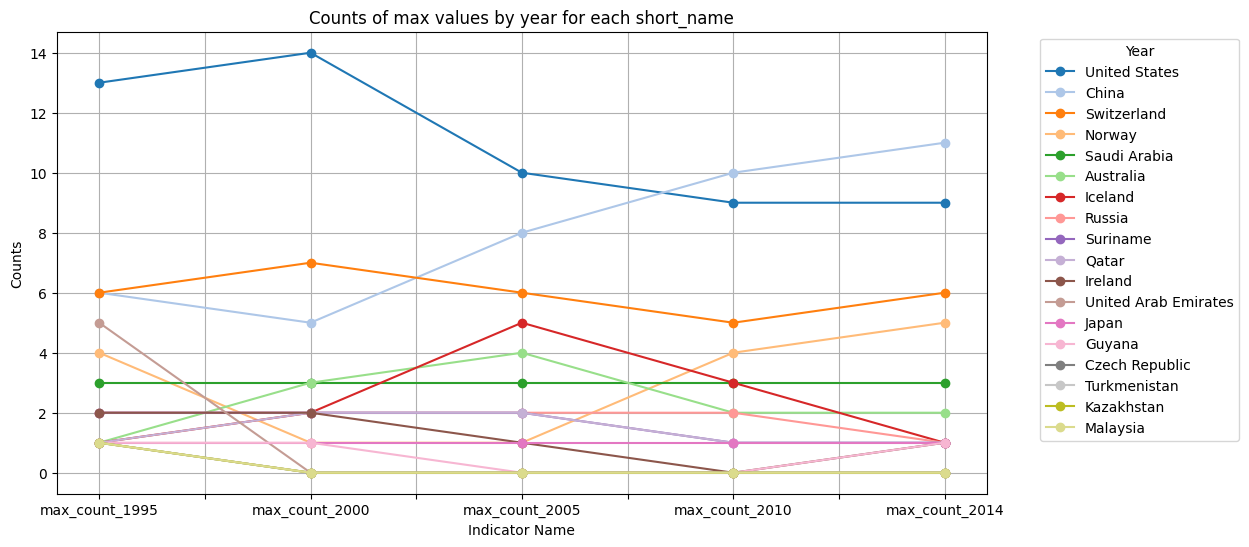

In [94]:
import matplotlib.pyplot as plt

# Create a copy of the DataFrame
short_name_counts_copy = short_name_counts.copy()

# Drop the 'sum_max_counts' column from the copy
short_name_counts_copy.drop(columns=['sum_max_counts'], inplace=True)

# Set the 'short_name' column as the index for easier plotting
short_name_counts_copy.set_index('short_name', inplace=True)

# Transpose the DataFrame to switch x-axis to y-axis
short_name_counts_transposed = short_name_counts_copy.T

# Define a custom color palette with 18 distinct colors
color_palette = plt.cm.tab20.colors[:18]

# Plot a line graph for each 'short_name' with the counts for each year
ax = short_name_counts_transposed.plot(kind='line', marker='o', figsize=(12, 6), color=color_palette)
plt.xlabel('Indicator Name')
plt.ylabel('Counts')
plt.title('Counts of max values by year for each short_name')
plt.grid(True)

# Place the legend outside the plot on the right side
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In this graph is possible to see that EUA was leading the top until 2005, but in 2010 China got highest values on more topics and started leading the ranking.

In [95]:
# close cursor and connection to prevent resource leaks and ensure efficient database operations.
cur.close()
conn.close()